# noaa-weather-hourly
This script cleans and formats a manually downloaded "National Oceanic and Atmospheric Administration" (NOAA) "LCD CSV" weather file.  This is the development version of the script, not the publishable version.

 __Originated From:__
https://github.com/emskiphoto/Process-historical-NOAA-LCD-weather<BR>
    
Copyright Matt Chmielewski<BR>
https://github.com/emskiphoto/noaa-weather-hourly<BR>
January 1, 2025

### Load Python packages

In [1]:
# direct the jupyter notebook development script to add package path to PYTHONPATH
# to allow for loading of source modules.
import sys
sys.path.append('../noaa-weather-hourly')

In [2]:
# import modules specific to this package 
from config import *
from utils import *

In [3]:
import pandas as pd
import csv
import pathlib
import re
# turn off Jedi autocomplete (that was causing more problems than benefits post Win10 update 3-13-2020)
%config Completer.use_jedi = False 

### Parameters - Store in config.py

In [4]:
is_development = True

### Command Line Arguments
Which arguments can be provided in the command line?

In [5]:
filename, freqstr

('', 'H')

## Locations

In [6]:
dir_cwd = pathlib.Path.cwd()
dir_cwd

WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev')

In [7]:
# using 'data' within 'dev' folder - potentially different from 'data' in package folder
# dir_data should be dir_cwd in production script
if is_development:
    dir_data = dir_cwd / 'data'
else:
    dir_data = dir_cwd
assert dir_data.is_dir()

#### Are there any .CSV files of any naming format?
If not, stop the script, there is nothing to do without the local .csv's.

In [8]:
# pretty name of directory
dir_data_posix = dir_data.as_posix()
# list of all .csv files in dir_data
dir_data_csv_files = sorted([f_.name for f_ in dir_data.glob('*.csv') if f_.is_file()])

In [9]:
# if 'filename' was provided, work with that .csv.
# if 'filename' was not provided, review available .csv's.
# if some .csv files are present, continue.  
# Otherwise halt process and inform user.
if filename == '':
    try:
        assert len(dir_data_csv_files) >= 1
    except:
        message_ = message_no_csv_files_found.format(
            dir_data_posix = dir_data_posix)
        print(message_)
    #     assert
        raise
# elif filename != '':
    
# string version of list of all csv files
dir_data_csv_files_str = ', '.join(dir_data_csv_files)

### Locate LCD .CSV file(s) 'files_lcd_input'
This script is intended to be executed from a terminal command line.  The LCD input file(s) are expected to be saved in the same directory that the command line is executed in.  The file name(s) are expected to match the pattern associated with multiple LCD file versions in 'patterns_lcd_input_files' (two versions currently).  However, if a file(s) with this pattern is not identifed, do NOT attempt to use any non-matching .CSV file in the same directory.  Inform user that no matching file was found and no files will be opened or created.

The benefits of this approach are:
1. code will not mistakenly use non-LCD files
2. User can be sloppy (or organized) with their LCD file storage.  New source files and output files can simply be accumulated in the same folder with no data loss.
3. Simple command line requires no mandatory input, only optional frequency and parameter setting inputs.

### which version of LCD files are avaialble and which are the most recent?
1. find all files that match v1 or v2 naming
2. find the most recent file
3. Determine if most recent file is v1 or v2 format 'lcd_version'
4. see if there is more than one file with the same station ID
5. create list 'files_lcd' with one or more lcd files of same station id 

In [10]:
# 1. find all files that match v1 or v2 naming and sort by last modified date descending
# create 'version_files' dictionary with LCD version number as key and list of matching 
# files as values
version_files = {v_ : find_files_re_pattern_sorted_last_modified(dir_data, pattern_) for
                 v_, pattern_ in version_pattern_lcd_input.items()}
version_files

{1: [WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/data/3876540.csv'),
  WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/data/3875753.csv')],
 2: [WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/data/LCD_USW00014939_2023.csv'),
  WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/data/LCD_USW00014939_2022.csv'),
  WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/data/LCD_USW00014939_2021.csv'),
  WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/data/LCD_USW00014939_2020.csv'),
  WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/data/LCD_USW00094846_2023.csv'),
  WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/data/LCD_USW00094846_2022.csv'),
  WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/data/LCD_USW00094846_2021.csv'),
  WindowsPath('C:/Us

In [11]:
files_pattern_match = [x for xs in version_files.values() for x in xs]

In [12]:
# what if no files were found?  
# return message and halt process
# which files matched lcd patterns, regardless of version or date?
# files_pattern_match = [x for xs in version_files.values() for x in xs]
try:
    assert len(files_pattern_match) >= 1
except:
    message_ = message_no_lcd_files_found.format(dir_data_posix = dir_data_posix,
                                 patterns_lcd_examples_str = patterns_lcd_examples_str,
                                dir_data_csv_files_str = dir_data_csv_files_str)
    print(message_)
#     assert
    raise

In [13]:
# find most recently modified file by lcd version
version_file_last_modified = {version_ : files_[0] for version_, files_ in version_files.items()}
version_file_last_modified

{1: WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/data/3876540.csv'),
 2: WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/data/LCD_USW00014939_2023.csv')}

In [14]:
# 2. find the most recent file
file_last_modified = sorted([(f, f.stat().st_mtime) for
                  f in version_file_last_modified.values()],
           key=lambda x: x[1], reverse=True)[0][0]
# 3. Determine if most recent file is v1 or v2 format 'lcd_version'
# versions start with '1' so need to add 1 to zero-indexed list
lcd_version = list(version_file_last_modified.values())\
                            .index(file_last_modified) + 1
# file_last_modified, lcd_version

In [15]:
# make sure we have the right version
assert file_last_modified in version_files[lcd_version]

### Group LCD .CSV input file(s) as 'files_lcd_input'

In [16]:
# 4. see if there is more than one file that has the same station ID
# as found in 'file_last_modified'
# This requires extraction of a unique identifier in LCD file name that is common to
# other LCD files for same location (but probably different dates).  

# Note that only the LCD v2 files need to be grouped.  LCD v1 files are 
# delivered with multi-year date ranges (if requested) while LCD v2
# files are for discrete calendar years (or less), for example 'LCD_USW00014939_2020.csv'.  

# Grouping LCD v1 files could be implemented, but this would require cooperation
# from the user in terms of renaming the LCD v1 files in a specific format.
# LCD v1 files are delivered with the same name ('3876540.csv') regardless
# of date range of data in file.    

In [17]:
# files_lcd_input - empty list to hold final, qualified selection of LCD input files
files_lcd_input = []
# different treatment for v2 LCD files
if lcd_version == 2:
# extract id_file_lcd2 as the blob of characters between first and second '_'
# reference 'LCD_USW00014939_2023.csv'
    id_file_lcd2 = file_last_modified.name.split('_')[1]
#     which files contain id for the current lcd_version?
    files_ = [file_ for file_ in version_files[lcd_version] if id_file_lcd2 in file_.name]
    files_lcd_input.extend(files_)
#     print('v2')
else:
    files_lcd_input.extend(file_last_modified)

In [18]:
# string version of filenames from files_lcd_input as vertical list
files_lcd_input_names_str = "\n".join([f_.name for f_ in files_lcd_input])
# files_lcd_input_names_str

### Keep only files that have one or more columns from cols_noaa_processed

#### Which columns are present by file in files_lcd_input?

In [19]:
# read only headers of each file in files_lcd_input
files_columns = {}
for file_ in files_lcd_input:
    try:
#         this is 30x faster than pd.read_csv(file_, index_col=0, nrows=0).columns.tolist()
        with open(file_, 'r') as infile:
            reader = csv.DictReader(infile)
            fieldnames = reader.fieldnames
        files_columns[file_] = sorted(fieldnames)
    except:
        continue

### Create files_usecols containing valid files and columns to be used

#### Is 'DATE' available for every file in files_lcd_input?

In [22]:
# keep only files that have a 'DATE' column - otherwise where is this data supposed to go?
files_usecols = {file_ : cols_ for file_, cols_ in files_columns.items() if 'DATE' in cols_}
# files_usecols

#### Keep only files that have at least one cols_data column

In [23]:
files_usecols = {file_ : cols_ for file_, cols_ in files_usecols.items()
                 if len(set(cols_).intersection(set(cols_data))) >=1}
# files_usecols

In [24]:
# reduce files_usecols to only columns used in this process
files_usecols = {file_ : sorted(set(cols_noaa_processed).intersection(set(cols_))) for
                 file_, cols_ in files_usecols.items()}
# files_usecols

### Open and Concatenate all files in files_usecols

In [25]:
df = pd.concat((pd.read_csv(f_, usecols=cols_, parse_dates=['DATE'],
                            index_col='DATE', low_memory=False) for
                f_, cols_ in files_usecols.items()), axis=0)\
                .reset_index().drop_duplicates()
df = df.set_index('DATE', drop=True).sort_index()
df

,STATION,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,Sunrise,Sunset
DATE,,,,,,,,,,,,,,,
2020-01-01 00:00:00,USW00014939,NaN,-6.1,-2.8,NaN,-1.9,78.0,967.9,NaN,-3.9,220.0,NaN,2.6,NaN,NaN
2020-01-01 00:00:00,USW00014939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,751.0,1709.0
2020-01-01 00:00:00,USW00014939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:54:00,USW00014939,1009.8,-7.8,-5.0,0.0,NaN,81.0,967.2,16.093,-5.9,170.0,NaN,2.6,NaN,NaN
2020-01-01 01:54:00,USW00014939,1008.1,-7.8,-4.4,0.0,NaN,77.0,965.5,16.093,-5.5,170.0,NaN,2.6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 20:54:00,USW00014939,1027.8,-6.1,-3.3,NaN,1.2,81.0,NaN,16.093,NaN,300,NaN,1.5,NaN,NaN
2023-12-31 21:00:00,USW00014939,NaN,-6.1,-3.3,NaN,1.2,81.0,984.3,16.0,-4.3,300,NaN,1.5,NaN,NaN
2023-12-31 21:54:00,USW00014939,1027.8,-7.8,-5.6,NaN,NaN,85.0,NaN,16.093,NaN,000,NaN,0.0,NaN,NaN


In [26]:
# keep track of the count of raw timestamps prior to processing
n_records_raw = df.shape[0]
# track statistics by column prior to processing, omit 'Sunrise' & 'Sunset' from stats
cols_sunrise_sunset = df.columns.intersection(['Sunrise', 'Sunset']).tolist()
df_stats_pre = df.loc[:, df.columns.difference(cols_sunrise_sunset)].describe()

In [27]:
# df = df[cols_use].copy()
df.shape

(50283, 15)

In [28]:
df.head()

,STATION,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,Sunrise,Sunset
DATE,,,,,,,,,,,,,,,
2020-01-01 00:00:00,USW00014939,NaN,-6.1,-2.8,NaN,-1.9,78.0,967.9,NaN,-3.9,220.0,NaN,2.6,NaN,NaN
2020-01-01 00:00:00,USW00014939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,751.0,1709.0
2020-01-01 00:00:00,USW00014939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:54:00,USW00014939,1009.8,-7.8,-5.0,0.0,NaN,81.0,967.2,16.093,-5.9,170.0,NaN,2.6,NaN,NaN
2020-01-01 01:54:00,USW00014939,1008.1,-7.8,-4.4,0.0,NaN,77.0,965.5,16.093,-5.5,170.0,NaN,2.6,NaN,NaN


### Identify and Display Weather Station Information

In [29]:
# v1 & v2
# identify WBAN station
station_lcd = str(df['STATION'].value_counts().index[0])
station_wban = station_lcd[6:]  #important - this is index for the isd-history table
station_lcd, station_wban

('USW00014939', '14939')

In [30]:
# remove 'STATION', 'REPORT_TYPE', 'SOURCE' columns - not needed anymore
df.drop(columns=['STATION', 'REPORT_TYPE', 'SOURCE'], inplace=True, errors='ignore')

#### Open 'isd-history.csv' containing Station details
This is supplemental, non-essential information.   It is important that any errors with this step do not negatively impact the core process.

In [31]:
isd_history_available = False
file_isd_history = find_latest_file(dir_data, pattern_isd_history_file)
if file_isd_history.is_file():
    isd_history_available = True

In [32]:
df_isd_history = pd.read_csv(file_isd_history, index_col='WBAN',
                             dtype={'WBAN': object}).sort_values(by=['USAF', 'BEGIN'],
                                                             ascending=[True, False])
df_isd_history.sample(5).sort_index()

,USAF,STATION NAME,CTRY,ST,CALL,LAT,LON,ELEV(M),BEGIN,END
WBAN,,,,,,,,,,
00145,949999,MAREEBAQWRC,AS,NaN,NaN,-17.000,+145.430,+0335.0,1956-12-31,1982-08-30
00320,A07049,PETALUMA MUNICIPAL AIRPORT,US,CA,KO69,+38.250,-122.600,+0027.1,2014-07-31,2024-12-15
04128,999999,RILEY 10 WSW,US,OR,NaN,+43.471,-119.692,+1396.9,2003-07-03,2024-12-15
23062,999999,DENVER STAPLETON AIRFIELD,US,CO,KDNR,+39.767,-104.883,+1626.1,1967-01-01,1972-12-31
26501,702220,GALENA AIRPORT,US,AK,PAGA,+64.737,-156.934,+0046.6,2006-01-01,2024-12-15


In [33]:
df_isd_history.loc[station_wban].reset_index()

,WBAN,USAF,STATION NAME,CTRY,ST,CALL,LAT,LON,ELEV(M),BEGIN,END
0,14939,725510,LINCOLN MUNICIPAL AIRPORT,US,NE,KLNK,+40.848,-096.765,+0356.7,1942-10-01,2024-12-16
1,14939,999999,LINCOLN AIR BASE,US,NE,KLNK,+40.851,-096.748,+0362.4,1948-01-01,1972-12-31


In [34]:
# df_isd_history.loc[int(station_wban)]
# using station_wban, gather station details from isd history for the record with the most
# recent 'END' date
station_details = dict(df_isd_history.loc[station_wban].reset_index()\
                       .sort_values('END', ascending=False).iloc[0])
# delete df_isd_history - no longer needed
del df_isd_history

In [35]:
# add url to google maps search of lat, lon values to station_details
google_maps_lat_lon_url = """https://maps.google.com/?q={lat},{long}"""
google_maps_url = google_maps_lat_lon_url.format(lat = station_details['LAT'],
                                                long = station_details['LON'])
station_details['GOOGLE MAP'] = google_maps_url
station_details

{'WBAN': '14939',
 'USAF': '725510',
 'STATION NAME': 'LINCOLN MUNICIPAL AIRPORT',
 'CTRY': 'US',
 'ST': 'NE',
 'CALL': 'KLNK',
 'LAT': '+40.848',
 'LON': '-096.765',
 'ELEV(M)': '+0356.7',
 'BEGIN': '1942-10-01',
 'END': '2024-12-16',
 'GOOGLE MAP': 'https://maps.google.com/?q=+40.848,-096.765'}

In [36]:
#     create timestamps for consolidated table df
start_dt = df.index[0]
end_dt = df.index[-1]
start_str = start_dt.strftime('%Y-%m-%d')
end_str = end_dt.strftime('%Y-%m-%d')
start_str, end_str

('2020-01-01', '2023-12-31')

In [ ]:
pd.DatetimeIndex()

In [74]:
pd.date_range(start_dt, end_dt, freq='H')

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', length=35064, freq='H')

In [94]:
# identify hours where no source data was provided
# This will be added as a boolean column later
idx_hours_no_source_data = pd.date_range(start_dt, end_dt, freq='H')\
                            .difference(df.index.round('H'))
n_hours_no_source_data = len(idx_hours_no_source_data)
# idx_hours_no_source_data

In [37]:
df.dtypes

HourlyAltimeterSetting       float64
HourlyDewPointTemperature    float64
HourlyDryBulbTemperature     float64
HourlyPrecipitation           object
HourlyPressureChange         float64
HourlyRelativeHumidity       float64
HourlyStationPressure        float64
HourlyVisibility              object
HourlyWetBulbTemperature     float64
HourlyWindDirection           object
HourlyWindGustSpeed          float64
HourlyWindSpeed              float64
Sunrise                      float64
Sunset                       float64
dtype: object

In [38]:
cols_dtypes = {'HourlyAltimeterSetting': 'float64',
   'HourlyDewPointTemperature': 'float64',
    'HourlyDryBulbTemperature': 'float64',
    'HourlyPrecipitation': 'float64',
    'HourlyPressureChange': 'float64',
    'HourlyRelativeHumidity': 'Int64',
    'HourlyStationPressure': 'float64',
    'HourlyVisibility': 'float64',
    'HourlyWetBulbTemperature': 'float64',
    'HourlyWindDirection': 'Int64',
    'HourlyWindGustSpeed': 'float64',
    'HourlyWindSpeed': 'float64',
    'Sunrise': 'float64',
    'Sunset': 'float64'}
#     'Sunrise': 'datetime64[s]',
#     'Sunset': 'datetime64[s]'}
# keep only items with corresponding column in df
cols_dtypes = {k : v for k, v in cols_dtypes.items() if k in df.columns}

In [39]:
# enforce dtypes for df
# does this need to be done on pre- df?  Is post- df processing enough?
for col_, type_ in cols_dtypes.items():
    if type_ == 'float64':
        df[col_] = pd.to_numeric(df[col_], errors='coerce')
        try:
            df[col_] = df[col_].astype(type_)
        except:
            pass
    elif type_ == 'Int64':
        df[col_] = pd.to_numeric(df[col_], errors='coerce')
        try:
            df[col_] = df[col_].astype(type_)
        except:
            pass

In [40]:
df.dtypes

HourlyAltimeterSetting       float64
HourlyDewPointTemperature    float64
HourlyDryBulbTemperature     float64
HourlyPrecipitation          float64
HourlyPressureChange         float64
HourlyRelativeHumidity         Int64
HourlyStationPressure        float64
HourlyVisibility             float64
HourlyWetBulbTemperature     float64
HourlyWindDirection            Int64
HourlyWindGustSpeed          float64
HourlyWindSpeed              float64
Sunrise                      float64
Sunset                       float64
dtype: object

#### Resolve duplicate datetime index values

In [41]:
df = df.groupby(level=0).mean()
df.shape

(48807, 14)

#### Extract Sunrise and Sunset by date in to dictionaries

to be applied
to df_out towards end of script.
Drop Sunrise and Sunset columns after extraction here
date_sunrise, date_sunset
The source data provides only one record per day and rest are NaN
additionally, resampling datetime values was causing dtype challenges

In [42]:
# create date_sunrise/sunset dictionaries with dates as keys and 
# timestamp values for time to be added back in to resampled df
date_sunrise = datetime_from_HHMM(df['Sunrise'].dropna()).to_dict()
date_sunset = datetime_from_HHMM(df['Sunset'].dropna()).to_dict()

In [43]:
# drop sunrise/sunset columns as their information is now 
# contained in the date_sunrise/sunset dictionaries
df.drop(columns=cols_sunrise_sunset, inplace=True, errors='ignore')

#### are there timestamps that have a high count of null values?
In v1 LCD files the '23:59:00' timestamp is suspect and appears to only be a placeholder
for posting sunrise/sunset times.  Important that this step be done after
forward filling sunrise/sunset values. 
V2 LCD files do not seem to have the '23:59:00' timestamp issue.

In [44]:
# n_records_hourly_approx = int(df.shape[0]/(24))
# n_max_null = pct_null_timestamp_max * n_records_hourly_approx
n_max_null = int(pct_null_timestamp_max * df.shape[0])
n_max_null

24403

In [45]:
temp = df.loc[:, df.columns.difference(cols_sunrise_sunset)]
df_nan_ts = temp.groupby(temp.index.time).apply(lambda x: x.isna().sum()\
                            .gt(n_max_null)).all(axis=1)
times_nan = df_nan_ts.loc[df_nan_ts].index.tolist()
del temp
del df_nan_ts

In [46]:
# remove records for timestamps with a high percentage of Null values.
# note that the '23:59:00' timestamp is suspect and appears to only be a placeholder
# for posting sunrise/sunset times.  Important that this step be done after
# forward filling sunrise/sunset values.
filter_nan_times = pd.Series(df.index.time).isin(times_nan).values
df = df.loc[~filter_nan_times]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48807 entries, 2020-01-01 00:00:00 to 2023-12-31 23:54:00
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HourlyAltimeterSetting     42846 non-null  float64
 1   HourlyDewPointTemperature  48754 non-null  float64
 2   HourlyDryBulbTemperature   48772 non-null  float64
 3   HourlyPrecipitation        34925 non-null  float64
 4   HourlyPressureChange       17481 non-null  float64
 5   HourlyRelativeHumidity     48754 non-null  Float64
 6   HourlyStationPressure      48642 non-null  float64
 7   HourlyVisibility           43696 non-null  float64
 8   HourlyWetBulbTemperature   48623 non-null  float64
 9   HourlyWindDirection        43923 non-null  Float64
 10  HourlyWindGustSpeed        8119 non-null   float64
 11  HourlyWindSpeed            48579 non-null  float64
dtypes: Float64(2), float64(10)
memory usage: 4.9 MB


In [47]:
test = df.between_time('23:01:00', '00:59:00').select_dtypes(include=[int, float])
test.groupby(test.index.time).sum()

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed
00:00:00,2019.6,5909.6,13355.7,1.7,429.2,102080.0,1390264.6,3130.854,9881.6,249289.0,0.0,5134.7
00:01:00,9151.4,73.1,97.4,0.0,0.0,760.0,8765.3,100.179,84.5,1820.0,18.0,42.8
00:02:00,8103.7,29.9,42.3,0.7,0.0,720.0,7761.7,61.556,36.8,1380.0,26.8,41.7
00:03:00,8129.1,52.2,76.7,0.5,0.0,648.0,7786.0,113.456,66.6,2100.0,14.4,43.8
00:04:00,6056.2,53.9,65.0,1.4,0.0,531.0,5800.4,73.223,59.2,500.0,11.3,32.5
...,...,...,...,...,...,...,...,...,...,...,...,...
23:54:00,1482354.9,6054.4,13670.9,100.1,438.3,104213.0,1411051.9,22073.600,10033.1,252780.0,1994.1,5220.0
23:56:00,2024.7,32.8,36.6,0.2,0.0,178.0,1939.2,18.507,34.2,390.0,13.9,10.8
23:57:00,1010.8,-10.0,-8.9,0.0,0.0,92.0,968.2,0.000,-9.2,360.0,0.0,1.5
23:58:00,4041.0,41.1,45.0,2.9,0.0,374.0,3870.2,17.702,43.0,460.0,12.9,20.1


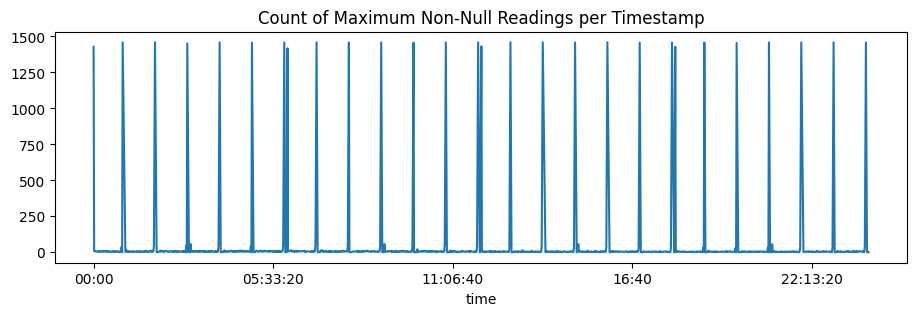

In [48]:
if is_development:
    df.groupby(df.index.time).count().max(axis=1).sort_index().plot(figsize=(11,3),
   title='Count of Maximum Non-Null Readings per Timestamp')

In [49]:
# df.loc[filter_nan_times]

In [50]:
#     Check what percentage of data has null data and print to screen
df_pct_null_data = pd.DataFrame({'Percent N/A': df.isnull().sum().divide(len(df)).round(3)})
df_pct_null_data_pre_formatted = df_pct_null_data['Percent N/A']\
                            .apply(lambda n: '{:,.1%}'.format(n))
# remove 'Hourly' prefix for display only
col_rename_remove_hourly = {col_ : col_.replace('Hourly', '') for
                            col_ in df_pct_null_data_pre_formatted.index}

#### Display Station Details

In [51]:
# exclude station lifetime history dates - could cause confusion
station_details_exclude = ['BEGIN', 'END']
station_details_display = {k_ : v_ for k_, v_ in station_details.items() if
                           k_ not in station_details_exclude}

In [52]:
print('--------------------------------------------')
print('------ ISD Weather Station Properties ------')
print('--------------------------------------------')
for k_, v_ in station_details_display.items():
    print("{:<15} {:<10}".format(k_, v_))
print('\n')

--------------------------------------------
------ ISD Weather Station Properties ------
--------------------------------------------
WBAN            14939     
USAF            725510    
STATION NAME    LINCOLN MUNICIPAL AIRPORT
CTRY            US        
ST              NE        
CALL            KLNK      
LAT             +40.848   
LON             -096.765  
ELEV(M)         +0356.7   
GOOGLE MAP      https://maps.google.com/?q=+40.848,-096.765




In [53]:
# message_pct_null_data = f"""Percent Missing Values by Column for LCD source file '{file_lcd_input.name}' for USAF station {station_usaf} at '{station_details['STATION NAME']}' from {start_str} to {end_str}."""
# message_pct_null_data = """Percent Missing Values by Column for LCD source file(s):
# {files_lcd_input_names_str}\n\nFor USAF station {station_usaf} at '{station_name}'
# from {start_str} to {end_str}."""
message_pct_null_data = """Percent Missing Values by Column from {start_str} to {end_str} for LCD source file(s):\n
{files_lcd_input_names_str}"""
message_ = message_pct_null_data.format(files_lcd_input_names_str = files_lcd_input_names_str,
                            station_usaf = station_details['USAF'],
                            station_name = station_details['STATION NAME'],
                            start_str = start_str,
                            end_str = end_str)

print(message_)

Percent Missing Values by Column from 2020-01-01 to 2023-12-31 for LCD source file(s):

LCD_USW00014939_2023.csv
LCD_USW00014939_2022.csv
LCD_USW00014939_2021.csv
LCD_USW00014939_2020.csv


In [54]:
print('--------------------------------------------------------------')
print('------ Percent Null Values by Column Before Processing -------')
print('--------------------------------------------------------------')
display(df_pct_null_data_pre_formatted.rename(index=col_rename_remove_hourly))

--------------------------------------------------------------
------ Percent Null Values by Column Before Processing -------
--------------------------------------------------------------


AltimeterSetting       12.2%
DewPointTemperature     0.1%
DryBulbTemperature      0.1%
Precipitation          28.4%
PressureChange         64.2%
RelativeHumidity        0.1%
StationPressure         0.3%
Visibility             10.5%
WetBulbTemperature      0.4%
WindDirection          10.0%
WindGustSpeed          83.4%
WindSpeed               0.5%
Name: Percent N/A, dtype: object

### Define Policy dictionaries for filling of Nulls and Resampling

#### How to handle Null values - col_null_policy

In [55]:
# # create dictionary 'col_null_policy' to manually guide the resolution of null values by column
# # in general, data that is expected to have a non-zero/non-null reading at all times
# # will have nulls filled through interpolation.  Data that normally has 0 or null readings
# # like 'HourlyPrecipitation' will have null values filled with 0 in the interest of having
# # a 100% clean dataset to facilitate manual analysis.
# col_null_policy = {'HourlyAltimeterSetting': pd.Series.interpolate,
#  'HourlyDewPointTemperature': pd.Series.interpolate,
#  'HourlyDryBulbTemperature': pd.Series.interpolate,
#  'HourlyPrecipitation': lambda x: x.fillna(0),
#  'HourlyPressureChange': pd.Series.interpolate,
#  'HourlyRelativeHumidity': pd.Series.interpolate,
#  'HourlyStationPressure': pd.Series.interpolate,
#  'HourlyVisibility': pd.Series.interpolate,
#  'HourlyWetBulbTemperature': pd.Series.interpolate,
#  'HourlyWindDirection': pd.Series.interpolate,
#  'HourlyWindGustSpeed': lambda x: x,
#  'HourlyWindSpeed': pd.Series.interpolate}
# #  'Sunrise': pd.Series.ffill,
# #  'Sunset': pd.Series.bfill}
# # keep only items with corresponding column in df
# col_null_policy = {k : v for k, v in col_null_policy.items() if k in df.columns}
# # assert len(df.columns.intersection(col_null_policy.keys())) == df.shape[1]

In [56]:
df.dtypes

HourlyAltimeterSetting       float64
HourlyDewPointTemperature    float64
HourlyDryBulbTemperature     float64
HourlyPrecipitation          float64
HourlyPressureChange         float64
HourlyRelativeHumidity       Float64
HourlyStationPressure        float64
HourlyVisibility             float64
HourlyWetBulbTemperature     float64
HourlyWindDirection          Float64
HourlyWindGustSpeed          float64
HourlyWindSpeed              float64
dtype: object

In [129]:
%%time
dfs = {}
# individually resample each column. This will produce series
# with perfect, complete datetime indexes.  However, it is quite
# possible that NaN values will remain.  Remaining NaN values will
# be resolved through interpolation later in the script.
# this method is used because NaN values can appear at different timestamps
# in each column
# at this point the df should contain only floats and ints
for col_ in df.columns:
    print(col_)
#     dfs[col_] = df[col_].dropna().resample(freqstr).agg(col_resample_policy[col_])
#     dfs[col_] = df[col_].dropna().resample(freqstr).mean()
    dfs[col_] = df[col_].dropna().resample('H').mean()
#     dfs1[col_] = df[col_].dropna().resample(freqstr).interpolate()

HourlyAltimeterSetting
HourlyDewPointTemperature
HourlyDryBulbTemperature
HourlyPrecipitation
HourlyPressureChange
HourlyRelativeHumidity
HourlyStationPressure
HourlyVisibility
HourlyWetBulbTemperature
HourlyWindDirection
HourlyWindGustSpeed
HourlyWindSpeed
CPU times: total: 62.5 ms
Wall time: 71.9 ms


In [130]:
df_out = pd.concat(dfs, axis=1).drop_duplicates().asfreq('H')
del dfs
# del df
df_out

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed
DATE,,,,,,,,,,,,
2020-01-01 00:00:00,1009.8,-6.95,-3.90,0.0,-1.9,79.5,967.55,16.0930,-4.9,195.0,NaN,2.60
2020-01-01 01:00:00,1008.1,-7.80,-4.40,0.0,NaN,77.0,965.50,16.0930,-5.5,170.0,NaN,2.60
2020-01-01 02:00:00,1007.5,-7.80,-4.40,0.0,-3.4,77.0,964.90,16.0930,-5.5,170.0,NaN,2.60
2020-01-01 03:00:00,1006.8,-7.80,-3.30,0.0,NaN,71.0,964.20,16.0930,-4.8,150.0,NaN,2.10
2020-01-01 04:00:00,1005.4,-6.70,-2.20,0.0,NaN,72.0,962.90,16.0930,-3.7,210.0,NaN,3.60
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,1027.4,-5.85,-2.20,NaN,NaN,76.5,NaN,16.0930,NaN,330.0,NaN,3.60
2023-12-31 20:00:00,1027.8,-6.10,-3.05,NaN,1.2,79.5,NaN,16.0930,NaN,310.0,NaN,1.50
2023-12-31 21:00:00,1027.8,-6.95,-4.45,NaN,1.2,83.0,984.30,16.0465,-4.3,150.0,NaN,0.75


In [131]:
# df['HourlyRelativeHumidity'].fillna(0).iloc[300:700].plot(lw=0.2, marker='o', markersize=2, figsize=(11,3))
# df['HourlyRelativeHumidity'].fillna(0).iloc[300:700].plot(lw=0.2, marker='o', markersize=2, figsize=(11,3))

In [133]:
# enforce dtypes for df_out
# does this need to be done on pre- df_out?  Is post- df_out processing enough?
# for col_, type_ in cols_dtypes.items():
for col_ in df_out.columns:
    type_ = cols_dtypes[col_]
    if type_ == 'float64':
        df_out[col_] = pd.to_numeric(df_out[col_], errors='coerce')
        try:
            df_out[col_] = df_out[col_].astype(type_)
        except:
            pass
    elif type_ == 'Int64':
        df_out[col_] = pd.to_numeric(df_out[col_], errors='coerce')
        try:
            df_out[col_] = df_out[col_].astype(type_)
        except:
            pass
#     elif type_ == 'datetime64[s]':
#         df_out[col_] = pd.to_datetime(df_out[col_], errors='coerce')
#         try:
#             df_out[col_] = df_out[col_].astype(type_)
#         except:
#             pass

# Resolve Sunrise/Sunset

In [134]:
# apply date_sunrise/sunset to df_out index to create sunrise/sunset columns
df_out['Sunrise'] = pd.Series(df_out.index.map(date_sunrise),
                              index=df_out.index).ffill().astype('datetime64[s]')
df_out['Sunset'] = pd.Series(df_out.index.map(date_sunset),
                             index=df_out.index).ffill().astype('datetime64[s]')

In [135]:
df_stats_post = df_out[df_stats_pre.columns].describe()
df_stats_post

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPressureChange,HourlyRelativeHumidity,HourlyStationPressure,HourlyWetBulbTemperature,HourlyWindGustSpeed,HourlyWindSpeed
count,34977.000000,34974.000000,34977.000000,17481.000000,34974.0,34878.000000,34874.000000,6651.000000,34861.000000
mean,1016.471511,4.339591,12.050943,0.000440,63.018099,973.569894,8.195601,12.974051,4.376544
std,7.490799,11.302829,12.407358,1.500063,19.029542,7.235153,10.603644,2.994208,2.905698
min,984.350000,-37.200000,-33.900000,-8.700000,10.0,942.575000,-34.000000,7.200000,0.000000
25%,1011.900000,-4.400000,2.200000,-0.900000,49.0,969.100000,0.000000,10.800000,2.100000
50%,1016.300000,3.900000,12.650000,0.000000,65.0,973.400000,8.300000,12.400000,4.100000
75%,1021.000000,15.000000,22.200000,0.900000,79.0,978.000000,17.800000,14.400000,6.200000
max,1044.000000,27.200000,40.600000,11.800000,100.0,1000.200000,29.300000,31.933333,17.833333


In [136]:
df_mean_comp = pd.concat([df_stats_pre.loc['mean'].T, df_stats_post.loc['mean'].T],
                         axis=1, keys=['Source Mean', 'Processed Mean']).round(2)
df_mean_comp['% Difference'] = df_mean_comp.pct_change(axis=1).iloc[:,-1]\
                                .mul(100).fillna(0).round(1)
df_mean_comp

,Source Mean,Processed Mean,% Difference
HourlyAltimeterSetting,1016.13,1016.47,0.0
HourlyDewPointTemperature,4.49,4.34,-3.3
HourlyDryBulbTemperature,11.44,12.05,5.3
HourlyPressureChange,0.00,0.0,0.0
HourlyRelativeHumidity,66.18,63.02,-4.8
HourlyStationPressure,973.28,973.57,0.0
HourlyWetBulbTemperature,7.98,8.2,2.8
HourlyWindGustSpeed,13.33,12.97,-2.7
HourlyWindSpeed,4.50,4.38,-2.7


In [137]:
df_mean_comp['% Difference'].mean()

-0.6000000000000001

In [138]:
# TO-DO:  Overall pre- post- statistics check
df_stats_pre.sub(df_stats_post).div(df_stats_pre).mean().mean()
# df_stats_pre.pct_change(df_stats_post)
# df_stats_pre.eq(df_stats_post).sum().sum()
# df_stats_pre.size

0.04220432878694552

In [139]:
# add column to document hourly obervations where no source data was provided.
df_out['No source data'] = df_out.index.isin(idx_hours_no_source_data)

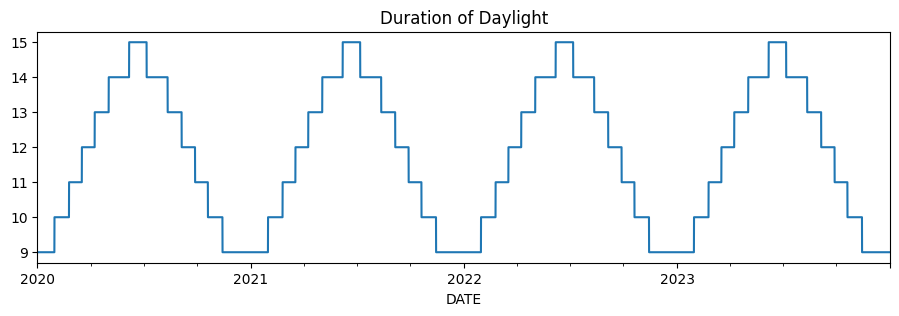

In [140]:
if is_development:
#     df_out[cols_sunrise_sunset].diff(axis=1).iloc[:,-1].dt.total_seconds().div(3600).plot()
    df_out[cols_sunrise_sunset].diff(axis=1).iloc[:,-1].div(3600).plot(
        title = 'Duration of Daylight', figsize = (11,3))

### Optional Frequency Resample

In [146]:
# # create dictionary 'col_resample_policy' to manually guide the resolution of null values by column
# # in general, data that is expected to have a non-zero/non-null reading at all times
# # will have nulls filled through interpolation.  Data that normally has 0 or null readings
# # like 'HourlyPrecipitation' will have null values filled with 0 in the interest of having
# # a 100% clean dataset to facilitate manual analysis.
col_resample_policy = {'HourlyAltimeterSetting': 'mean',
 'HourlyDewPointTemperature': 'mean',
 'HourlyDryBulbTemperature': 'mean',
 'HourlyPrecipitation': 'mean',
 'HourlyPressureChange': 'mean',
 'HourlyRelativeHumidity': 'mean',
 'HourlyStationPressure': 'mean',
 'HourlyVisibility': 'mean',
 'HourlyWetBulbTemperature': 'mean',
 'HourlyWindDirection': 'mean',
 'HourlyWindGustSpeed': 'mean',
 'HourlyWindSpeed': 'mean',
 'Sunrise': pd.Series.mode,
 'Sunset': pd.Series.mode}
# # keep only items with corresponding column in df_out
col_resample_policy = {k : v for k, v in col_resample_policy.items() if k in df_out.columns}
# # assert len(df.columns.intersection(col_resample_policy.keys())) == df.shape[1]

<Axes: xlabel='Sunrise'>

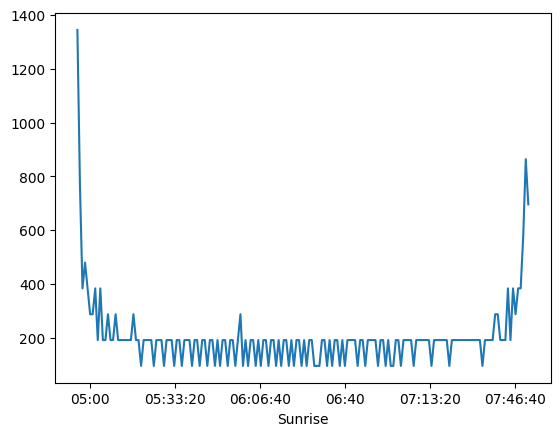

In [150]:
df_out['Sunrise'].dt.time.value_counts().sort_index().plot()

In [ ]:
if df_out.index.freqstr != freqstr:
    for col_ in df_out.columns.intersection(cols_data)
    
    df_out = df_out.resample()

In [ ]:
# df.agg(col_null_policy).astype(cols_dtypes)
# df.agg(col_null_policy).isna().sum()

In [ ]:
# transform remaining null values per the 'col_null_policy'
# df = df.agg(col_null_policy).astype(cols_dtypes)
# display(pd.DataFrame({'Percent N/A': df.isnull().sum().divide(len(df))\
#                       .round(3)}).apply(lambda n: '{:,.1%}'.format(n)))

In [ ]:
#     Check what percentage of data has null data and print to screen
df_pct_null_data_post = pd.DataFrame({'Percent N/A': df_out.isnull().sum().divide(len(df_out)).round(3)})
df_pct_null_data_post_formatted = df_pct_null_data_post['Percent N/A'].apply(lambda n: '{:,.1%}'.format(n))
display(df_pct_null_data_post_formatted.rename(index = col_rename_remove_hourly))

In [ ]:
display(df_pct_null_data_pre_formatted.rename(index=col_rename_remove_hourly))

In [ ]:
df_pct_null_data_pre_formatted

In [ ]:
for col_ in df.columns:
    print(col_)
    df[col_].resample(freqstr)

In [ ]:
df.dtypes

In [ ]:
pd.to_numeric(df['HourlyVisibility'])

In [ ]:
pd.to_datetime(df['Sunrise'])

In [ ]:
df.resample(freqstr).mean()

In [ ]:
#     Resample data to produce evenly spaced interval data
# df = df.resample(freqstr).median()
df = df.resample(freqstr).mean()

### Quality Control

#### No duplicate records

#### Complete and consistent timestamps

#### correct dtypes

#### Nan values only in columns permitted to have NaN

## Create Additional Columns (not implemented)

In [ ]:
# #     assign seasons to df in new 'season' column
#     df = weather_assign_season(df)
# #     assign weekend or weekday tag to each day
#     df['weekday'] = 'weekday'
#     df.loc[~df.index.weekday.isin(list(range(0,5))),'weekday'] = 'weekend'
#     df['weekday'] = df['weekday'].astype('category')   # keep memory size to a minimum
# #     Add True/False Peak Coincident column
#     df = is_month_and_hour_in_list(df, new_column='Peak Coincident', months=[6,7,8,9],hours=[14,15,16,17])
# #     Add holiday True/False:
#     years = list(df.index.year.unique())
#     try:
#         holiday_dates = generate_list_of_holidays(years=years)
#         holiday_YMD = []
#         for d in holiday_dates:
#             holiday_YMD.append(datetime.datetime(d.year, d.month, d.day).date())
#         df['holiday'] = [dat in holiday_YMD for dat in df.index.date]
# #         alternatively:
# # holiday_dates = generate_list_of_holidays(years=df.index.year.unique().to_list())
# # df['Date_copy_delete'] = df.index.date.copy()
# # df['holiday'] = df.Date_copy_delete.apply(lambda date: date in holiday_dates)
# # df.drop(columns=['Date_copy_delete'], inplace=True)
#     except:
#         print("Holidays were not tagged.  Veritfy it 'Holidays' python package is installed")
# #     Add temperature bins
#     temp_bins = list(range(-30,110,5))
#     df['DryBulbTemperature_bin'] = pd.cut(df['HourlyDryBulbTemperature'],bins=temp_bins)

### Export df to Disk

#### Rename Columns - remove 'hourly' from names

#### Name export file 

In [ ]:
# city = input("Input city or project name:  ")
# export_name = "{}_".format(city) + start_str + "_to_" + end_str + f"_{df.index.freqstr}.csv"
# export_name

In [ ]:
file_output_format.format(STATION_NAME = 'billy',
                         )

In [ ]:
file_out_name = f"{station_details['']city) + start_str + "_to_" + end_str + f"_{df.index.freqstr}.csv"
file_out = dir_cwd / file_out_name
file_out_name

In [ ]:
# os.path.join(os.path.dirname(file),export_name)

In [ ]:
[col.replace('Hourly','') for col in df.columns]

In [ ]:
df.columns

In [ ]:
df.to_csv(os.path.join(os.path.dirname(file),export_name))
# os.path.join(os.path.dirname(directory),f'All_M_V_data {todays_date}.csv')

# END